In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

### Предобработка и оценка данных

In [345]:
houses_raw_df = pd.read_csv('houses.csv', sep=',', index_col='Id')
houses_raw_df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
844,90,RL,80.0,8000,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,141000
1145,190,RL,60.0,12180,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,7,2010,WD,Normal,80000
1089,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,137500
1000,20,RL,64.0,6762,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2010,WD,Normal,206000
1196,60,RL,51.0,8029,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,176000


In [346]:
print(
    f"Sample dimensionality: {houses_raw_df.shape}",
    f"Has {len(houses_raw_df[houses_raw_df.duplicated()])} row duplicates",
    f"Has id {len(houses_raw_df[houses_raw_df.index.duplicated()])} duplicates",
    f"Has {len(houses_raw_df[houses_raw_df['SalePrice'].isna()])} regression target `SalePrice` skips",
    f"Has {len(houses_raw_df[houses_raw_df['OverallCond'].isna()])} classification target `OverallCond` skips",
    sep="\n"
)

Sample dimensionality: (1460, 80)
Has 0 row duplicates
Has id 0 duplicates
Has 0 regression target `SalePrice` skips
Has 0 classification target `OverallCond` skips


In [347]:
# Удалим признаки для которых много пропусков
_to_remove = houses_raw_df.columns[houses_raw_df.count() < 800]
houses_raw_df.drop(_to_remove, axis=1, inplace=True)

houses_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemodAdd 

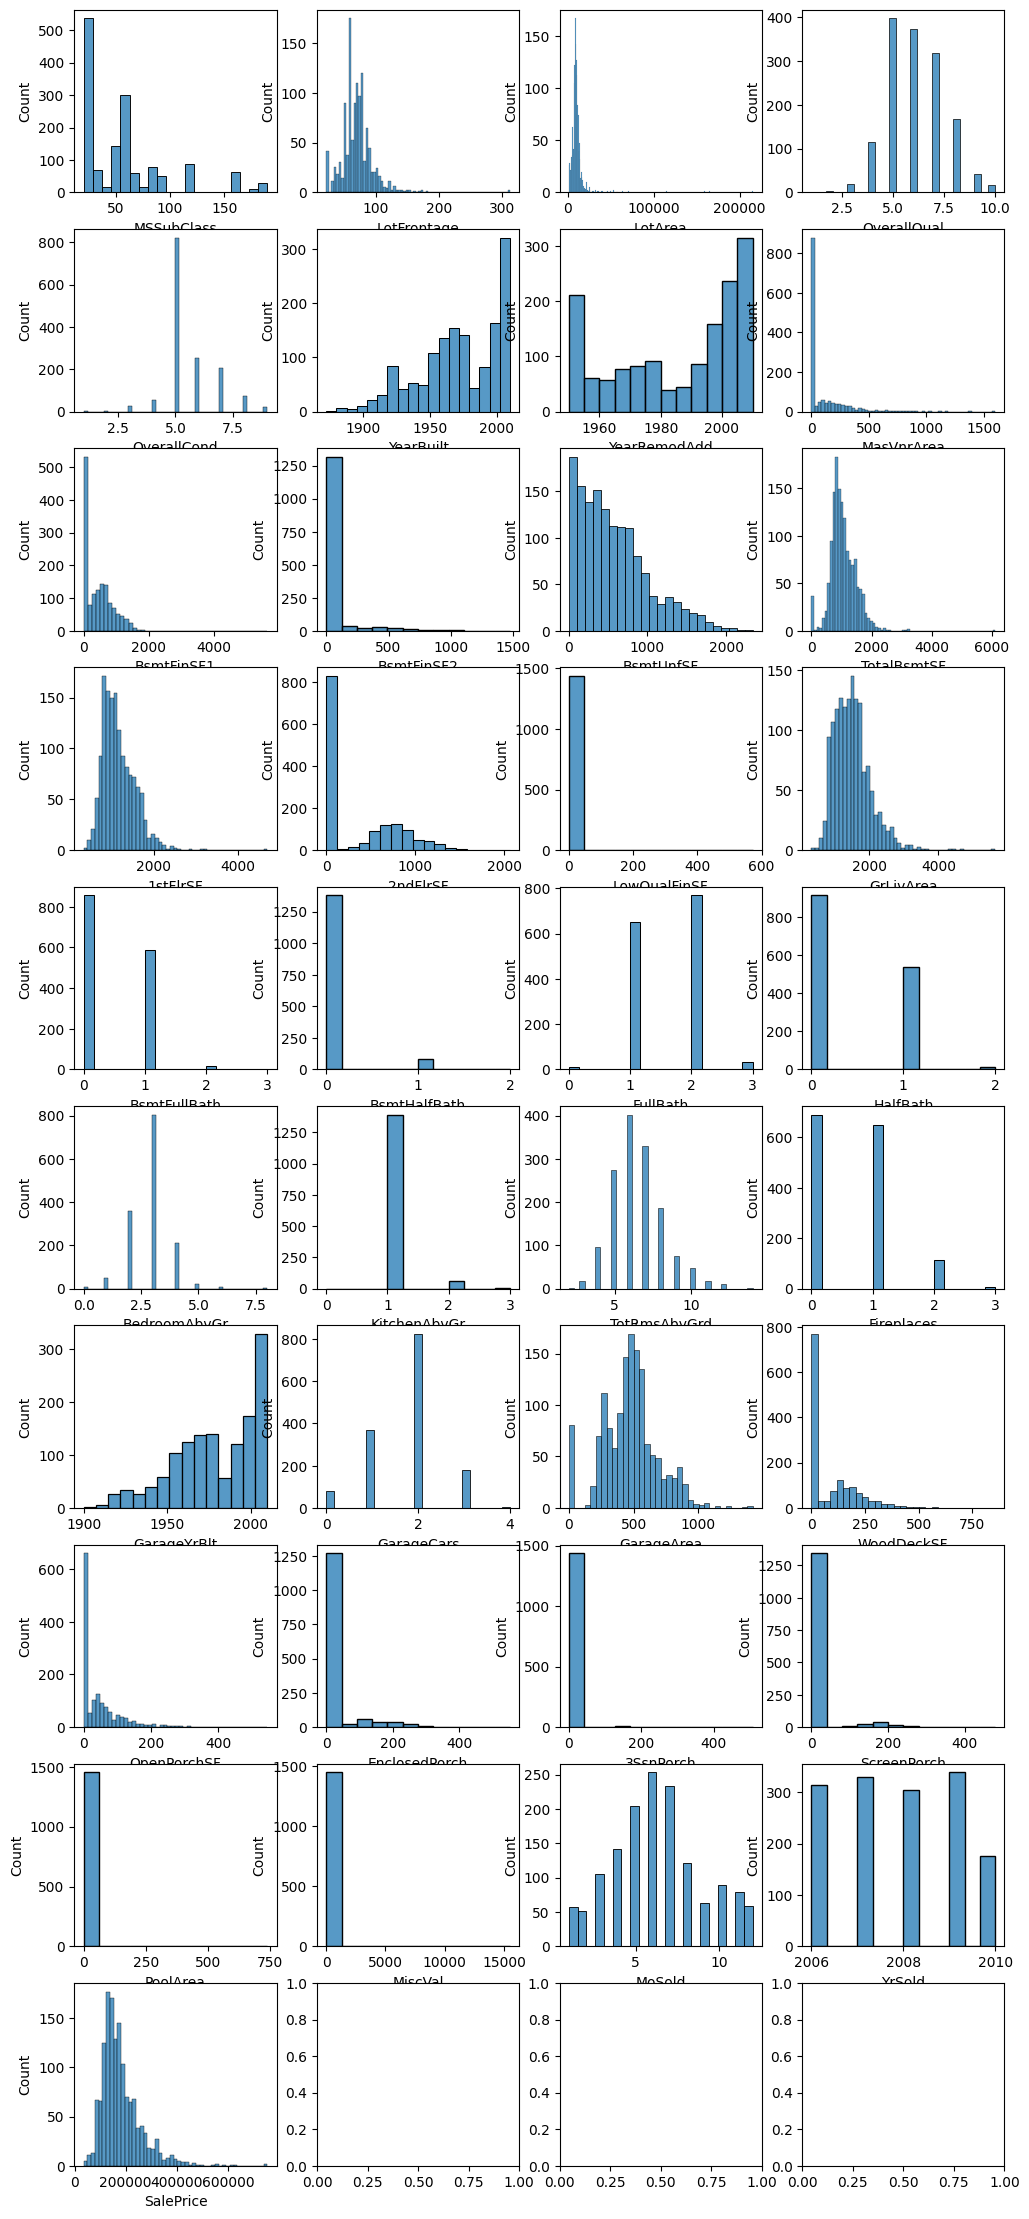

In [348]:
def check_for_quality_number_scales():
    number_cols = houses_raw_df.select_dtypes(include='number').columns

    _columns = 4
    _rows = int(np.ceil(len(number_cols) / _columns))

    fig, ax = plt.subplots(nrows=_rows, ncols=_columns, figsize=(12, 28))
    ax = ax.flatten()

    for idx, number_col in enumerate(number_cols): # Есть качественные шкалы которые лучше преобразовать к категориальным
        sns.histplot(
            houses_raw_df,
            x=houses_raw_df[number_col],
            ax=ax[idx]
        )
    
check_for_quality_number_scales() # Нужно преобразовать  качественные шкалы к категориальным

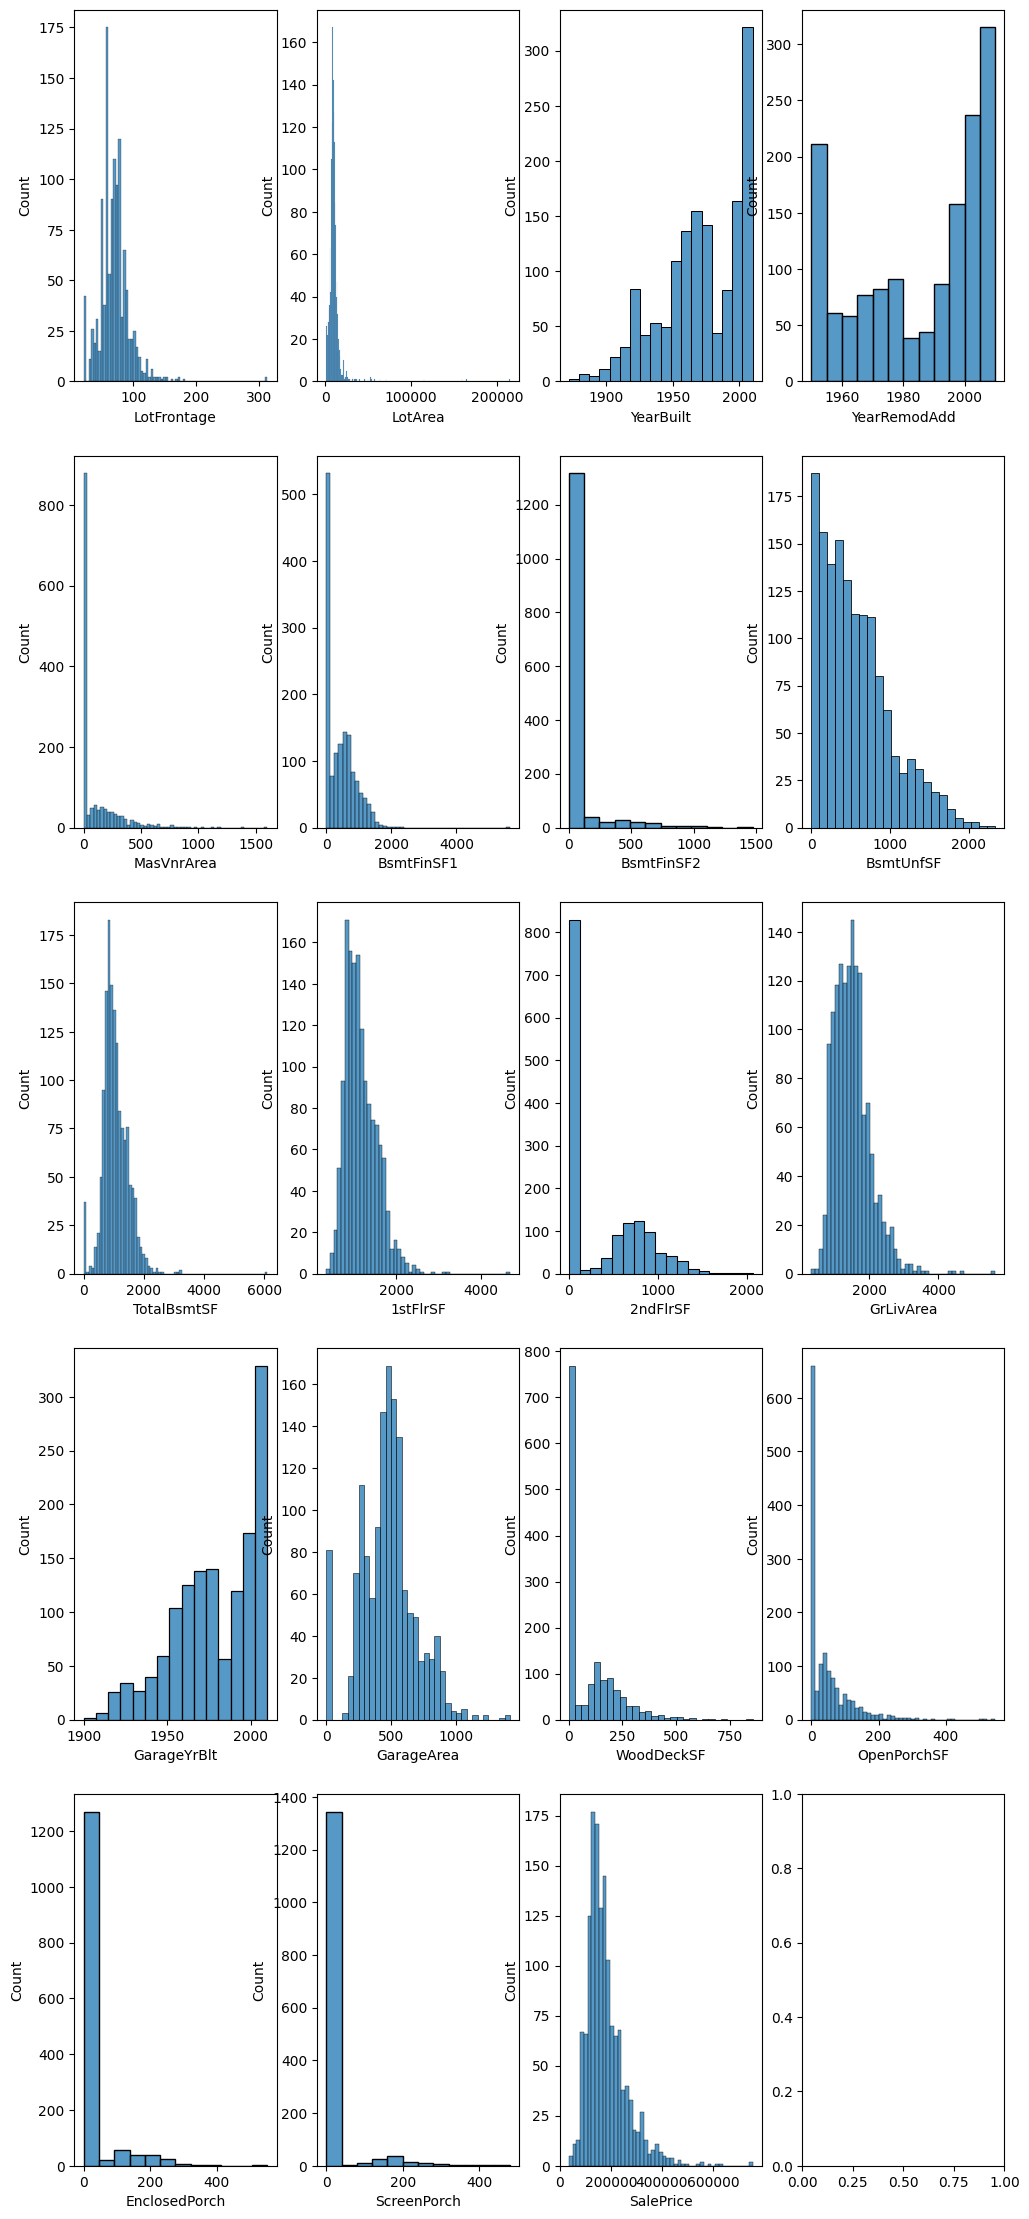

In [349]:
to_cat = []
for column in houses_raw_df.select_dtypes(include='number').columns:
    if len(houses_raw_df[column].value_counts().index) < 25:
        to_cat.append(column)
        
for quality_col in to_cat:
    houses_raw_df[quality_col] = houses_raw_df[quality_col].astype(object)
check_for_quality_number_scales() # Выглядит криво, но стало лучше

# Также можем заметтить, что есть много распределений где поможет чистка от выбросов или логарифмирование

In [350]:
# Удалим бесполезные категориальные признаки
for cat_col in houses_raw_df.select_dtypes(exclude='number').columns:
    _overall = houses_raw_df[cat_col].count()
    _most_samples = houses_raw_df[cat_col].value_counts().iloc[0]
    _coef = _most_samples / _overall
    if _coef > 0.9:
        print(f"removing feature {cat_col}, coef f{_coef}")
        houses_raw_df.drop(cat_col, axis=1, inplace=True)


removing feature Street, coef f0.9958904109589041
removing feature Utilities, coef f0.9993150684931507
removing feature LandSlope, coef f0.9465753424657535
removing feature Condition2, coef f0.9897260273972602
removing feature RoofMatl, coef f0.9821917808219178
removing feature BsmtCond, coef f0.921293042867182
removing feature Heating, coef f0.9780821917808219
removing feature CentralAir, coef f0.934931506849315
removing feature Electrical, coef f0.914324880054832
removing feature LowQualFinSF, coef f0.9821917808219178
removing feature BsmtHalfBath, coef f0.9438356164383561
removing feature KitchenAbvGr, coef f0.9534246575342465
removing feature Functional, coef f0.9315068493150684
removing feature GarageQual, coef f0.9506889050036258
removing feature GarageCond, coef f0.9615663524292966
removing feature PavedDrive, coef f0.9178082191780822
removing feature 3SsnPorch, coef f0.9835616438356164
removing feature PoolArea, coef f0.9952054794520548
removing feature MiscVal, coef f0.9643835

In [351]:
NUM_COLS = houses_raw_df.select_dtypes(include='number').columns
CAT_COLS = houses_raw_df.select_dtypes(exclude='number').columns

## Regression

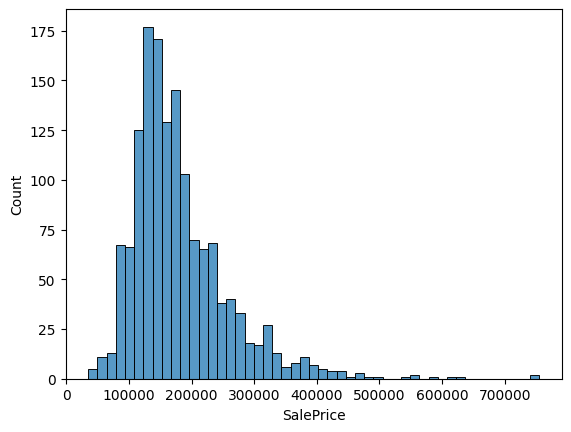

In [352]:
# Посмотрим как выглядит распределение целевой переменной. 
# Удалим признаки которые слабо влияют на целевую перменную
REGRESSION_TARGET = "SalePrice"
sns.histplot( 
    houses_raw_df,
    x=REGRESSION_TARGET
) # Неплохо бы избавиться от выбросов

regression_df = houses_raw_df.copy()

In [353]:
# Удалим признаки которые особо не коррелируют с ценой. 
correlations = houses_raw_df[NUM_COLS].corr()
_to_remove = []
for row in correlations.index:
    if abs(correlations.loc[row, REGRESSION_TARGET]) < 0.2:
        _to_remove.append(row)
regression_df.drop(_to_remove, axis=1, inplace=True)

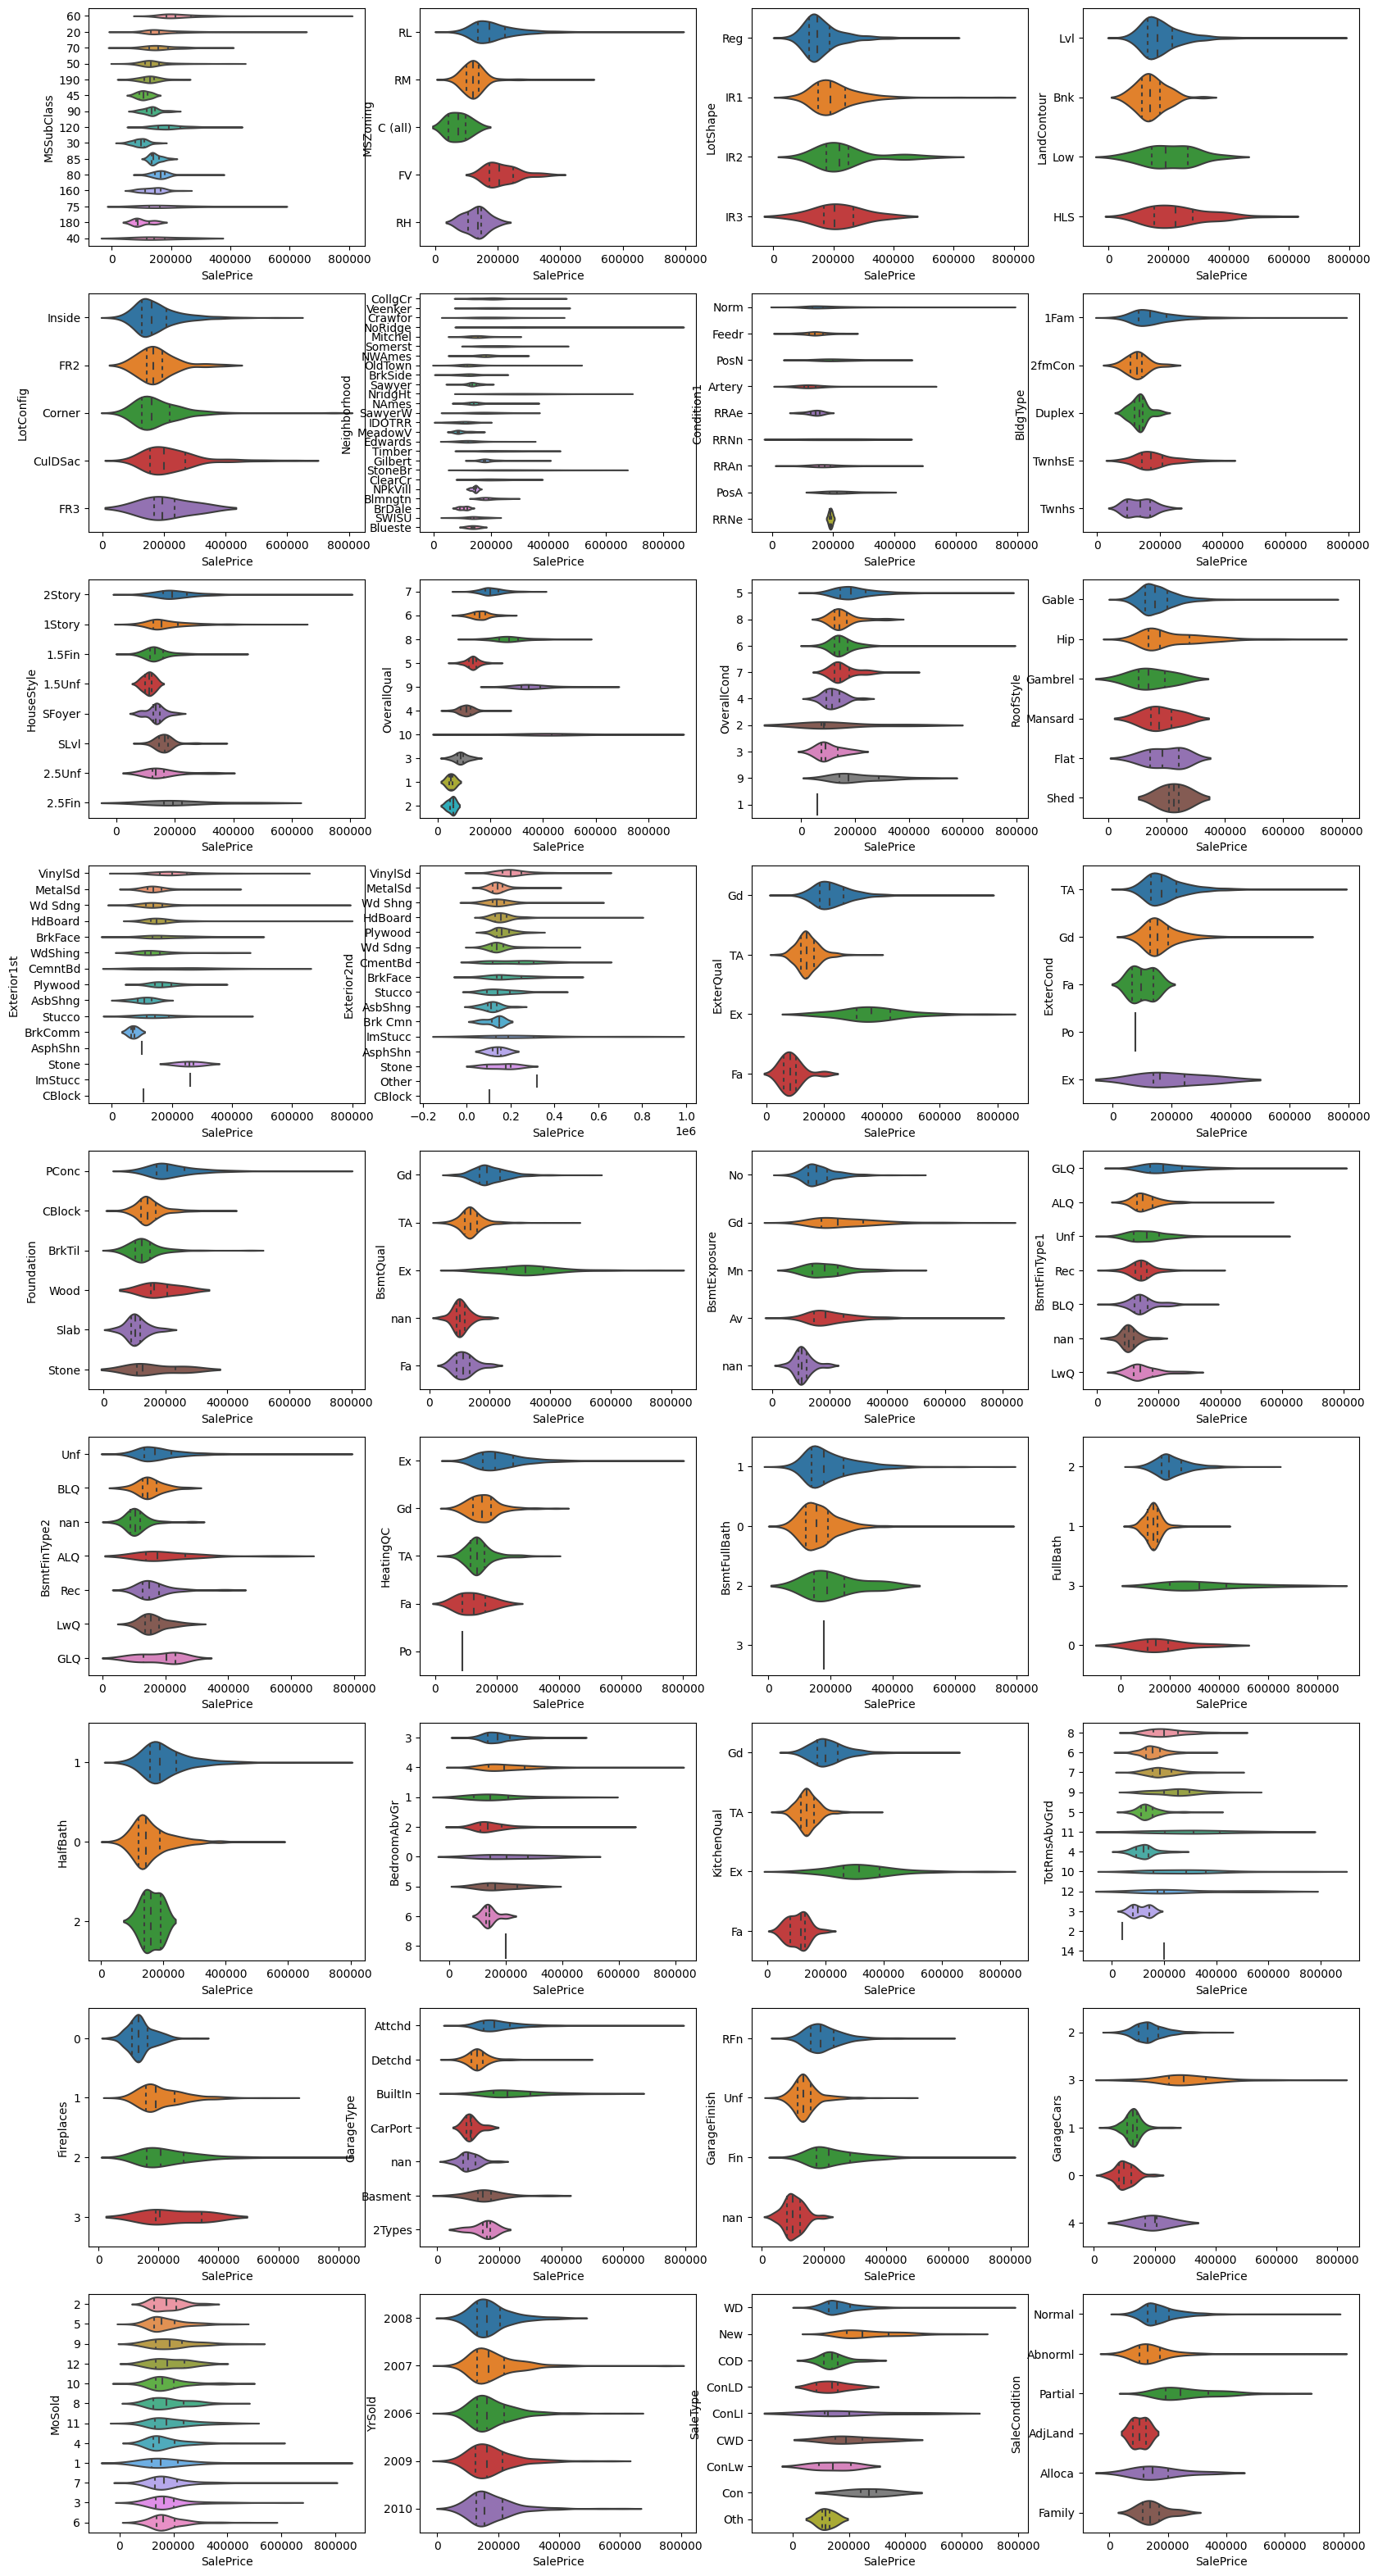

In [354]:
# Посмотрим вариативность каких категориальных признаков не имеет особо значения

_cols = 4
_rows = int(np.ceil(len(CAT_COLS) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 40))
ax = ax.flatten()

for idx, cat_col in enumerate(CAT_COLS): # Есть относительно бесплезные признаки, котоыре не влияют на цену. Удалим их
    sns.violinplot(
        regression_df,
        x=regression_df[REGRESSION_TARGET],
        y=regression_df[cat_col].astype(str),
        ax=ax[idx],
        orient='h',
        split=True,
        inner = "quartile"
    )
    
regression_df.drop(["YrSold", "HalfBath", "MoSold", "BsmtFinType1"], axis=1, inplace=True) # Остальное вроде ок.
# За шакальное кол-во графиков извиняюсь

In [355]:
# Создадим пайплайн

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()), # StandardScaler or MinMaxScaler
    ('NCA', NeighborhoodComponentsAnalysis(n_components=8))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ("num", num_pipe, regression_df.select_dtypes(include="number").columns.drop(REGRESSION_TARGET)),
    ("cat", cat_pipe, regression_df.select_dtypes(exclude="number").columns)
])

model_pipe = Pipeline([
    ("preprocessing", preprocessors),
    ("model", KNeighborsRegressor(n_neighbors=13, weights="distance"))
])

In [356]:
X_train, X_test, y_train, y_test = train_test_split(
    regression_df.drop(REGRESSION_TARGET, axis=1),
    regression_df[REGRESSION_TARGET],
    test_size=0.2,
    random_state=43
)

In [357]:
def regression_metrics(model_pipe, X_test, y_test):
    y_hat = model_pipe.predict(X_test)
    print("r2_score: ", r2_score(y_hat, y_test))
    print("rmse: ", np.sqrt(mean_squared_error(y_hat, y_test)))
    print("mae: ", mean_absolute_error(y_hat, y_test))

In [358]:
model_pipe.fit(X_train, y_train)
regression_metrics(model_pipe, X_test, y_test) # В целом неплохо, но впервый раз когда я делал было лучше. Пройдемся по сетке

r2_score:  0.7595993782322639
rmse:  36181.7051230804
mae:  22371.790309507756


In [359]:
param_grid = {
    "preprocessing__num__NCA__n_components": np.arange(4, 12, 3),
    "model__n_neighbors": np.arange(6, 30, 4),
    "model__weights": ["uniform", "distance"]
}
pipe_gs = GridSearchCV(estimator=model_pipe,
                       param_grid=param_grid,
                       cv=KFold(n_splits=5))

In [360]:
pipe_gs.fit(X_train, y_train)

In [ ]:
best_estimator = pipe_gs.best_estimator_
regression_metrics(best_estimator, X_test, y_test)

r2_score:  0.7560133150781342
rmse:  38033.05498783743
mae:  23193.07163653466


/Users/pyretttt/masters/mle2/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/Users/pyretttt/masters/mle2/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<Axes: >

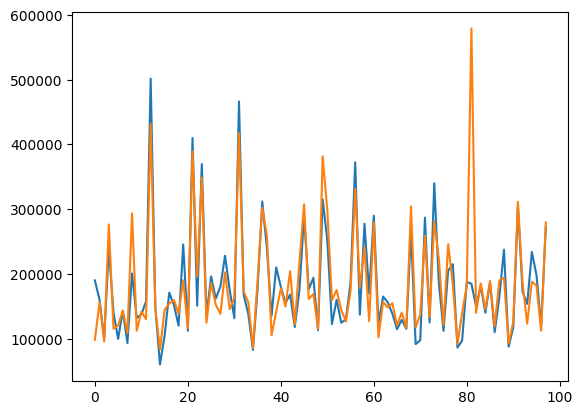

In [ ]:
y_hat = best_estimator.predict(X_test)
sns.lineplot(y_test.values[::3])
sns.lineplot(y_hat[::3])
# В целом то неплохо подхватываем опредленные моменты. Но не хватает точности и есть какой-то странный выброс